In [1]:
#https://colab.research.google.com/drive/1WIk2bxglElfZewOHboPFNj8H44_VAyKE?usp=sharing#scrollTo=ZwQIEhKOrJpl

In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, GPT2Config, GenerationConfig
import nltk
import evaluate
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from encoder import CustomEncoder
from pickle import load
from matplotlib.pylab import plt
from numpy import arange
import pandas as pd

Dataloader

In [2]:
path =  os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))

def read_data():
    output = []
    dir_path = os.path.join(path,'Data', 'analyzed_imgs')
    dir = os.listdir(dir_path)
    for file in dir:
        if "p11" not in file:
            with open(os.path.join(dir_path, file), "rb") as input_file:
                dict = load(input_file)
            output.append(dict)
    return output 

In [3]:
data = read_data()

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained(os.path.join(path, 'Code', 'Video_Analysis', 'Models', 'tokenizer_v2'))

In [6]:
class video2reportDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        data = self.data[idx]
        
        input = torch.stack(([data['icd_icpm']]+data['frames']))           
        
        opbericht = data['Ablauf']    
        opbericht = f"<|startoftext|>{opbericht.strip()}<|endoftext|>"
        # Tokenize target
        target = self.tokenizer.encode_plus(opbericht,
                                              truncation=True,
                                              padding='max_length',
                                              max_length = 1024,
                                              return_tensors='pt')

        return {"inputs": input, 
                "labels": torch.squeeze(target['input_ids'],0), 
                "attn_mask": torch.squeeze(target['attention_mask'],0)}

Model

In [7]:
class video2report(nn.Module):
    def __init__(self, decoder_name):
        super().__init__()
        self.encoder = CustomEncoder(d_model=768, num_layers=12, num_heads=12, d_ff=1024)
        configuration = GPT2Config.from_pretrained(decoder_name, is_decoder = True, add_cross_attention = True, loss_type = 'ForCausalLMLoss')
        self.decoder = GPT2LMHeadModel.from_pretrained(decoder_name, config=configuration)
    
    def forward(self, x, inputs, attn_mask):
        x = self.encoder(x)

        out = self.decoder(input_ids = inputs, labels = inputs, attention_mask= attn_mask, encoder_hidden_states = x)
        return out
    
    def generate(self, x, inputs, attn_mask, generation_config):
        x = self.encoder(x)

        output = self.decoder.generate(inputs = inputs,
                                       generation_config = generation_config,
                                       attention_mask = attn_mask,
                                       encoder_hidden_states = x)
        
        return output

In [ ]:
val_loss = load(open(os.path.join(path,'Code', 'Video_Analysis', 'Models', 'folds_eval_loss.pkl'), 'rb'))

val_loss

In [ ]:
decoder = os.path.join(path, 'Code', 'Text_Generation', 'Models', 'pretrained_gpt2_v2')
model = video2report(decoder_name=decoder)
model.load_state_dict(torch.load(os.path.join(path,'Code', 'Video_Analysis', 'Models', 'video2report_fold_2.pth'), weights_only=True))

Testing

In [10]:
test = load(open(os.path.join(path,'Code', 'Video_Analysis', 'Models', 'test_data_fold_2.pkl'), 'rb'))
reference = test[0]['Ablauf'] 
test_data = video2reportDataset(test, tokenizer=tokenizer)

In [ ]:
len(test_data.__getitem__(0)['inputs'])

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [13]:
greedy_config = GenerationConfig(max_new_tokens = 128,
                            do_sample = True, 
                            top_k = 50, 
                            top_p = 0.85,
                            renormalize_logits = True)

beam_config = GenerationConfig(max_new_tokens = 32,
                            early_stopping = True,
                            do_sample = True, 
                            top_k = 50, 
                            top_p = 0.85,
                            num_beams = 4,
                            renormalize_logits = True)

In [14]:
batch = test_data.__getitem__(0)
b_input_ids = batch['inputs'].to(device) 

In [15]:
def infer(prompt):
    input = f"<|startoftext|>{prompt.strip()}"
    input = tokenizer(input, return_tensors='pt')
    input_ids      = input["input_ids"]
    attention_mask = input["attention_mask"]

    return input_ids, attention_mask

In [57]:
text_input = infer('Ablauf:')

In [ ]:
out = model.generate(x = b_input_ids.unsqueeze(0), inputs = text_input[0].to(device), attn_mask = text_input[1].to(device), generation_config=greedy_config)

In [ ]:
out = model.generate(x = b_input_ids.unsqueeze(0), inputs = out, attn_mask = torch.ones(out.size()[1], device=device).unsqueeze(0), generation_config=greedy_config)

In [ ]:
prediction = tokenizer.decode(out[0], skip_special_tokens=True)

print(prediction)

In [85]:
df = pd.read_excel(os.path.join(path,'Code', 'Video_Analysis', 'results.xlsx'))



In [78]:
df.to_excel(os.path.join(path,'Code', 'Video_Analysis', 'results.xlsx'), index=False)

In [80]:
from sentence_transformers import SentenceTransformer

In [87]:
df_results = pd.DataFrame(columns=['Video','Gr R1', 'Gr R2', 'Gr RL', 'Gr SeSi', 'Be R1', 'Be R2', 'Be RL', 'Be SeSi'])

metric = evaluate.load("rouge")
eval_model = SentenceTransformer("all-MiniLM-L6-v2")

for index, row in df.iterrows():
    reference = [row['reference']]
    greedy = [row['greedy']]
    beam = [row['beam']]

    rogue_greedy = metric.compute(predictions=greedy, references=reference)
    rogue_beam = metric.compute(predictions=beam, references=reference)

    embed_pred = eval_model.encode(reference)
    embed_greedy = eval_model.encode(greedy)
    embed_beam = eval_model.encode(beam)

    sesi_greedy = eval_model.similarity(embed_pred, embed_greedy)
    sesi_beam = eval_model.similarity(embed_pred, embed_beam)

    df_results.loc[len(df_results)] = [row['Video'], rogue_greedy['rouge1'], rogue_greedy['rouge2'], rogue_greedy['rougeL'], sesi_greedy.item(), 
                                        rogue_beam['rouge1'], rogue_beam['rouge2'], rogue_beam['rougeL'], sesi_beam.item()]
    

df_results.to_excel(os.path.join(path,'Code', 'Video_Analysis', 'metrics.xlsx'), index=False)

In [88]:
df_results

,Video,Gr R1,Gr R2,Gr RL,Gr SeSi,Be R1,Be R2,Be RL,Be SeSi
0,p1,0.870515,0.798122,0.833073,0.952219,0.916905,0.885057,0.916905,0.987767
1,p2,0.900421,0.855134,0.892006,0.924655,0.916905,0.879310,0.911175,0.979657
2,p3,0.843931,0.794203,0.841040,0.809241,0.843931,0.791304,0.838150,0.809241
3,p4,0.815267,0.725881,0.787786,0.809241,0.809668,0.715152,0.779456,0.809241
4,p5,0.719562,0.650206,0.651163,0.815734,0.911932,0.871795,0.900568,0.977397
5,p6,0.790932,0.722222,0.773300,0.836771,0.801027,0.738739,0.788190,0.801240
6,p7,0.842434,0.754304,0.808112,0.914826,0.841941,0.753532,0.807512,0.917525
7,p8,0.788148,0.704309,0.755556,0.873048,0.801187,0.705357,0.762611,0.880682
8,p9,0.957516,0.937705,0.954248,0.964256,0.920684,0.892356,0.917574,0.884399
9,p10,0.939617,0.918759,0.936672,0.840587,0.961538,0.949555,0.961538,0.859704


In [96]:
import numpy as np

In [89]:
df = pd.read_excel(os.path.join(path,'Code', 'Video_Analysis', 'metrics.xlsx'))

In [90]:
greedy = df[['Gr R1', 'Gr R2', 'Gr RL', 'Gr SeSi']]
beam = df[['Be R1', 'Be R2', 'Be RL', 'Be SeSi']]
labels = ['ROGUE-1', 'ROGUE-2', 'ROGUE-L', 'Semantic Similarity']

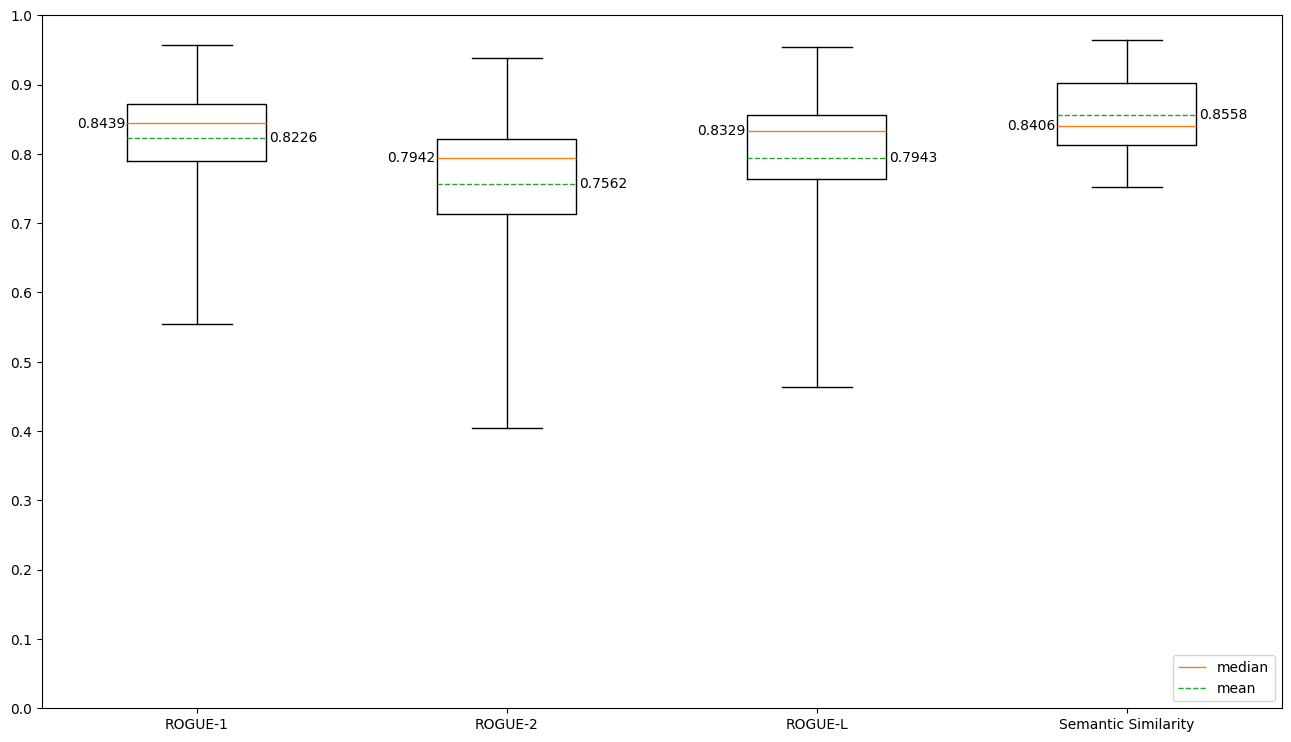

In [100]:
fig = plt.figure(figsize=(16, 9))

bplot = plt.boxplot(greedy, vert = True, whis = (0,100), labels = labels, patch_artist=False, showmeans=True, meanline=True)

for line in bplot['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.annotate('%.4f' % y,(x-0.61, y),
                 verticalalignment='center')

for line in bplot['means']:
    x, y = line.get_xydata()[1] # bottom of left line
    plt.annotate('%.4f' % y,(x+0.01, y),
         verticalalignment='center')
    
plt.ylim(0, 1)
plt.yticks(np.arange(0,1.1,0.1))
plt.legend([bplot['medians'][0], bplot['means'][0]], ['median', 'mean'], loc = 4)
plt.show()

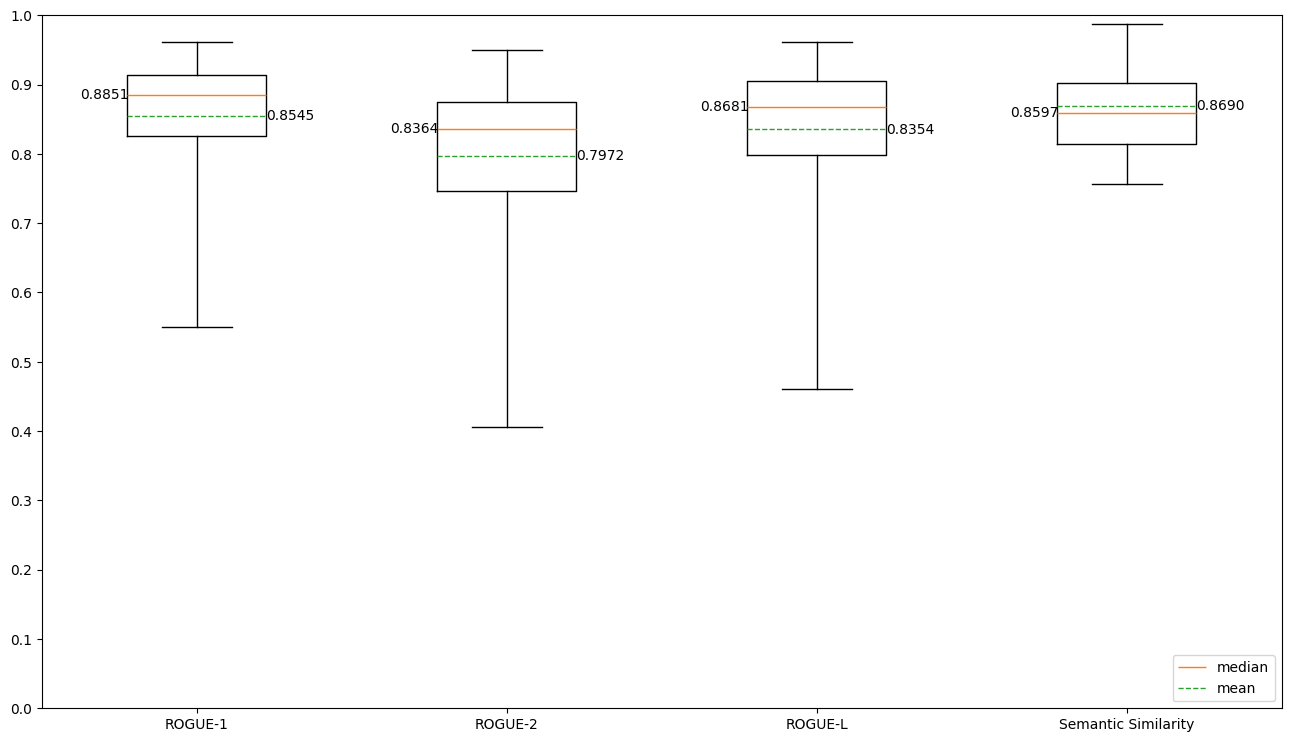

In [101]:
fig = plt.figure(figsize=(16, 9))

bplot = plt.boxplot(beam, vert = True, whis = (0,100), labels = labels, patch_artist=False, showmeans=True, meanline=True)

for line in bplot['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.annotate('%.4f' % y,(x-0.6, y),
                 verticalalignment='center')

for line in bplot['means']:
    x, y = line.get_xydata()[1] # bottom of left line
    plt.annotate('%.4f' % y,(x, y),
         verticalalignment='center')
plt.ylim(0, 1)
plt.yticks(np.arange(0,1.1,0.1))   
plt.legend([bplot['medians'][0], bplot['means'][0]], ['median', 'mean'], loc = 4)

plt.show()